In [ ]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from statsmodels.tsa.arima.model import ARIMA

In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
# vamos importar a base de produção de energia elétrica
df = pd.read_excel('energy.xlsx', index_col='DATE', parse_dates=True)
df.head()

energy
DATE               
1985-01-01  71.5920
1985-02-01  69.7870
1985-03-01  61.6790
1985-04-01  56.7479
1985-05-01  54.6165

In [ ]:
# quantas linhas e colunas?
df.shape

(408, 1)

In [ ]:
# Estatística descritiva
df.describe()

energy
count  408.000000
mean    88.062232
std     15.168540
min     54.616500
25%     76.499750
50%     88.940450
75%     99.733200
max    126.362600

In [ ]:
# Quando começam e terminam os dados?
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [ ]:
df.columns = ['producao']

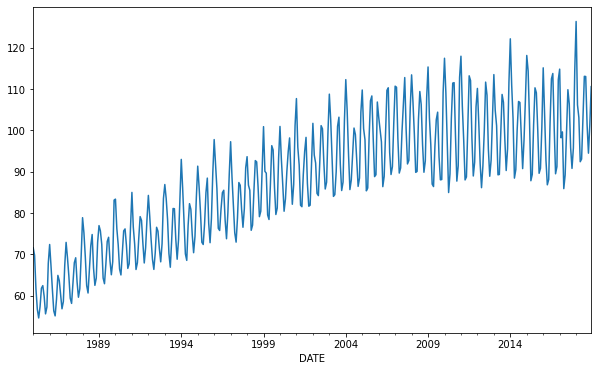

In [ ]:
# Vamos dar uma olhada no gráfico de consumo x anos
df['producao'].plot(figsize=(10,6))


<Figure size 576x432 with 0 Axes>

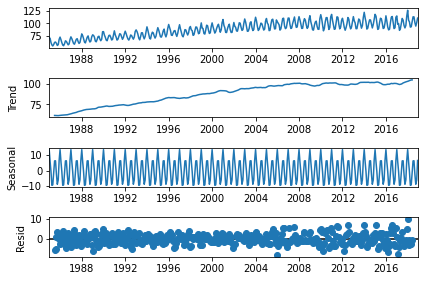

In [ ]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

In [ ]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.252399047046584
p-valor:0.18777984601968167


In [ ]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].diff().dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-7.450892277526348
p-valor:5.6745699558553634e-11


In [ ]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1968.148, Time=0.92 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2494.965, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2053.701, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2128.799, Time=0.65 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2064.883, Time=1.46 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=1.36 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1928.298, Time=2.92 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=2.04 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=1868.200, Time=5.08 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=1866.400, Time=4.37 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2014.153, Time=2.11 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=1916.488, Time=2.82 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=1936.850, Time=2.94 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=1868.120, Time=6.23 sec
 ARIMA(1,1,2)(1,1,2)[6]             : AIC=1

In [ ]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(1,1,1),  seasonal_order=(1, 1, 2, 6))
resultado_sarimax = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# resultados do modelo SARIMAX(2,1,2)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                               producao   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Thu, 20 Oct 2022   AIC                           1866.400
Time:                                        19:35:23   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.065      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.181      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [ ]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(115.14474825026089, 124.45517746431635)

In [ ]:
predicao_media[0]

119.79996285728862

In [ ]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

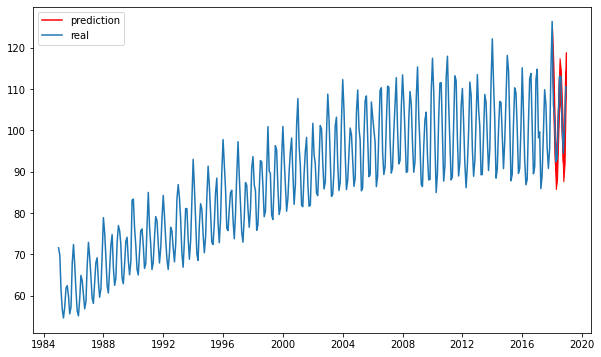

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-12:].values,predicao_media.values))
print(rmse_sarima)

3.4262789603631325


##FORECAST COM ARIMA

In [ ]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [ ]:

intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(91.38813221555213, 103.10930917451398)

In [ ]:
forecast_medio[10]

97.24872069503306

In [ ]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

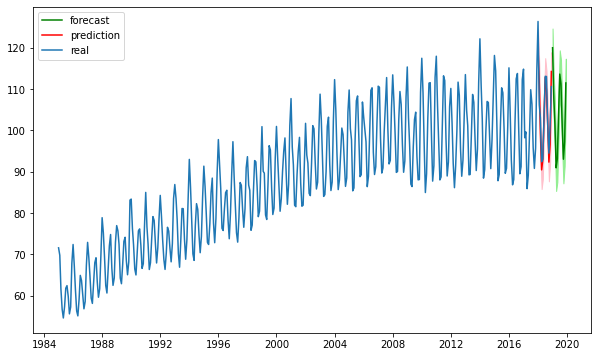

In [ ]:

dates=np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

In [ ]:
from xgboost import XGBRegressor

In [ ]:
treino = df.loc[df.index < "2016-12-31"]
validacao = df.loc[df.index > "2016-12-31"]

treino.shape, validacao.shape

((384, 1), (24, 1))

In [ ]:
treino.head()

producao
DATE                
1985-01-01   71.5920
1985-02-01   69.7870
1985-03-01   61.6790
1985-04-01   56.7479
1985-05-01   54.6165

In [ ]:
treino["target"] = treino["producao"].shift(-1)
treino.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


producao   target
DATE                         
1985-01-01   71.5920  69.7870
1985-02-01   69.7870  61.6790
1985-03-01   61.6790  56.7479
1985-04-01   56.7479  54.6165
1985-05-01   54.6165  57.3509

In [ ]:
treino.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
validacao["target"] = validacao["producao"].shift(-1)
validacao.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


producao   target
DATE                         
2017-01-01  114.8282  98.2191
2017-02-01   98.2191  99.6408
2017-03-01   99.6408  85.9106
2017-04-01   85.9106  89.2053
2017-05-01   89.2053  99.1945

In [ ]:
validacao.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
x_treino = treino.loc[:, ["producao"]].values
y_treino = treino.loc[:, ["target"]].values
x_validacao = validacao.loc[:, ["producao"]].values
y_validacao = validacao.loc[:, ["target"]].values

In [ ]:
modelo_xgba = XGBRegressor()
modelo_xgba.fit(x_treino, y_treino)

[19:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
validacao.iloc[0]

producao    114.8282
target       98.2191
Name: 2017-01-01 00:00:00, dtype: float64

In [ ]:
predicao = modelo_xgba.predict(x_validacao)
predicao

array([104.399086,  95.61575 , 103.10387 ,  85.04508 ,  94.05464 ,
        98.045296, 103.522705, 103.06118 ,  96.16103 ,  97.07032 ,
        96.16103 , 104.22538 , 110.307556, 102.25154 , 101.48239 ,
        93.75535 ,  90.328575, 101.48239 , 111.06515 , 111.06515 ,
       101.72752 ,  94.60005 , 101.72752 ], dtype=float32)

In [ ]:
validacao["pred"] = predicao
validacao.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


producao   target        pred
DATE                                     
2017-01-01  114.8282  98.2191  104.399086
2017-02-01   98.2191  99.6408   95.615753
2017-03-01   99.6408  85.9106  103.103867
2017-04-01   85.9106  89.2053   85.045082
2017-05-01   89.2053  99.1945   94.054642

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(x_validacao, predicao)

3.586096144701088